# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 

## Preparation

In [2]:
df = pd.read_csv('/Users/joemeyer/Library/Mobile Documents/com~apple~CloudDocs/Work Folder/TripleTen_Sprint13/data/taxi.csv', 
                 index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
# Removing larger outliers over small because the higher amounts are more unlikely
df = df[df['num_orders'] <= 60]

In [11]:
print(df.duplicated().sum())
print(df.index.duplicated().sum())

26398
0


There are a lot of duplicates in the data but all of them are value based and not actual duplicate timestamps. The value based duplicates are most likely harmless because these values could represent patterns and seasonality within the data.

In [ ]:
df.sort_index(inplace=True)
df = df['2018-03-01' : '2018-08-31']
df = df.resample('1H').sum()

/var/folders/yw/r2f7lm0x4vgcgy9bmg3hm1f80000gn/T/ipykernel_76505/3932920068.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').sum()


In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [ ]:
df['rolling_24'] = df['num_orders'].rolling(24).mean()

## Analysis

<Axes: xlabel='datetime'>

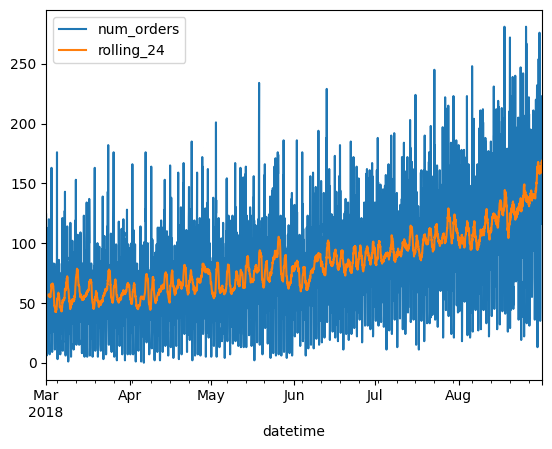

In [ ]:
df.plot()

Here we can see the number of orders every hour from March to August 2018. The rolling mean is the orange line meant to smooth out the really spiking points. Our window for the rolling mean is 24 which takes to the mean of the amount of orders everyday. Next we will be using seasonality to spot any trends and then evenutally lag so the model can understand what is changing recently. 

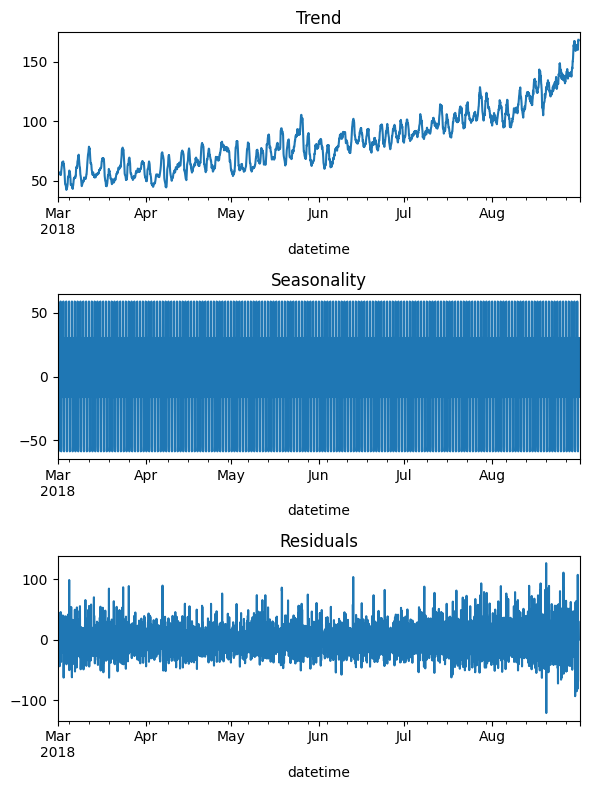

In [ ]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Here we can see that there is a clear upward trend from March to August. This can be due to seasonal changes like tourism and warm weather change. In seasonality there is a clear repetitive patteren in a 24 hour period. This confirms that hourly data will be easy to predict, likely due to morning/evening rush hours. As for the residuals, it's steady for the most part except for the occasional spikes. This means that the trend and seasonality explain most of the variance, which is great for modeling

In [ ]:
df['trend'] = decomposed.trend
df['seasonality'] = decomposed.seasonal
df['resid'] = decomposed.resid
df['lag_1'] = df['num_orders'].shift(1)
df['lag_24'] = df['num_orders'].shift(24)

Here I added some feautures for the model training. I added some lag features that represent 1 hour and 24 hours. This will help our model understand what happened 1 hour ago which will help predict the next hour and 24 hours ago to try and recognize daily patterns.

In [ ]:
df.dropna(inplace=True)
df.head(10)

,num_orders,rolling_24,trend,seasonality,resid,lag_1,lag_24
datetime,,,,,,,
2018-03-02 00:00:00,90,55.416667,54.833333,58.795699,-23.629032,58.0,124.0
2018-03-02 01:00:00,120,56.875000,55.229167,19.068923,45.701911,90.0,85.0
2018-03-02 02:00:00,75,57.041667,55.416667,23.650548,-4.067215,120.0,71.0
2018-03-02 03:00:00,64,56.958333,55.187500,17.733540,-8.921040,75.0,66.0
2018-03-02 04:00:00,20,56.000000,55.854167,0.781354,-36.635521,64.0,43.0
2018-03-02 05:00:00,11,56.208333,57.479167,-40.911610,-5.567557,20.0,6.0
2018-03-02 06:00:00,11,56.166667,58.625000,-58.531259,10.906259,11.0,12.0
2018-03-02 07:00:00,7,55.833333,59.041667,-54.453049,2.411382,11.0,15.0
2018-03-02 08:00:00,46,56.333333,59.791667,-10.561428,-3.230239,7.0,34.0


## Training

In [ ]:
df['target'] = df['num_orders'].shift(-1)
df.dropna(inplace=True)

x = df.drop(['num_orders', 'target'], axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=12345)


## Testing

In [ ]:
lr = LinearRegression()
lr.fit(x_train, y_train)

lrx_pred = lr.predict(x_test)

rmse = root_mean_squared_error(y_test, lrx_pred)

print(f'RMSE for Linear Regression is: {rmse:.2f}')

RMSE for Linear Regression is: 27.77


Great, even a basic model like Linear Regression got a solid baseline score. I used Linear Regression specifically as a baseline and sanity check for our later more complex models. So far with the features that we have added, even a basic model is well under the project requirements fro RMSE. After this the other more complex models should be able to get a lower score, if they don't we'll be able to tell that there's something wrong with the model

In [ ]:
rf = RandomForestRegressor(n_estimators=500, random_state=12345, max_depth=10)
rf.fit(x_train, y_train)

rfx_pred = rf.predict(x_test)

rf_rmse = root_mean_squared_error(y_test, rfx_pred)

print(f'RMSE for Random Forest Regression is: {rf_rmse:.2f}')

RMSE for Random Forest Regression is: 21.88


As expected, a more complex model was able to get a better score. Random Forest is not "time aware", but with lag and rolling features, it can get enough data to learn patterns and predict them

In [ ]:
lgb = lgb.LGBMRegressor(random_state=12345, n_estimators=500, learning_rate=0.03, max_depth=6)
lgb.fit(x_train, y_train)

lgbx_pred = lgb.predict(x_test)

lgb_rmse = root_mean_squared_error(y_test, lgbx_pred)

print(f'RMSE for LightLGB is: {lgb_rmse:.2f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3941, number of used features: 6
[LightGBM] [Info] Start training from score 83.885055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

## Conclusion

This project aimed to build a model that accurately forecasts the number of hourly taxi orders, with a target RMSE not exceeding **48**. After thorough data preparation — including resampling, feature engineering, and outlier removal — three models were evaluated:

####  Final RMSE Scores (after outlier removal)

| Model                    | RMSE     |
|-------------------------|----------|
| Linear Regression        | 27.77    |
| Random Forest Regressor | 21.88    |
| **LightGBM Regressor**  | **20.73** ✅ |

---

### Key Insights

- Removing outliers improved RMSE across all models, most notably in **Linear Regression**, which dropped from 31.12 to 27.77.
- Both **Random Forest** and **LightGBM** performed exceptionally well, capturing the non-linear patterns in demand.
- **LightGBM** had the lowest RMSE and trains faster, making it well-suited for real-time or large-scale deployment.

---

### Final Recommendation

> **Deploy the LightGBM model** for predicting hourly taxi orders.  
> Its high accuracy and speed make it the best-performing and most practical choice for Sweet Lift Taxi’s operational needs.
